# Stroke Risk Analysis Using Healthcare Data

Stroke merupakan salah satu penyebab kematian tertinggi di dunia. Deteksi dini faktor risiko dapat membantu pencegahan. Project ini bertujuan untuk menganalisis faktor-faktor yang paling berkontribusi terhadap risiko stroke menggunakan data kesehatan pasien.

## Load Data

In [1]:
# Library 

import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn import svm

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB

In [2]:
# Load Data
df = pd.read_csv('healthcare-dataset-stroke-data.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


## Data Understanding

In [3]:
df.shape

(5110, 12)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [5]:
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


## Data Cleaning & Preparation

In [6]:
df.drop(columns='id', inplace=True)

In [7]:
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [8]:
df['bmi'].fillna(df['bmi'].median(), inplace=True)

In [9]:
df.isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

Temuan:

* Kolom id tidak memiliki nilai analitis → hanya identifier
* Variabel bmi memiliki missing value (~4%)

Insight:

Dataset relatif bersih dengan tingkat missing value rendah. Missing value pada BMI kemungkinan berasal dari keterbatasan pencatatan data medis, dan diatasi dengan imputasi median agar distribusi tetap stabil tanpa terpengaruh outlier.

## Exploratory Data Analysis (EDA)

### Distribusi Stroke (Class Imbalance) 

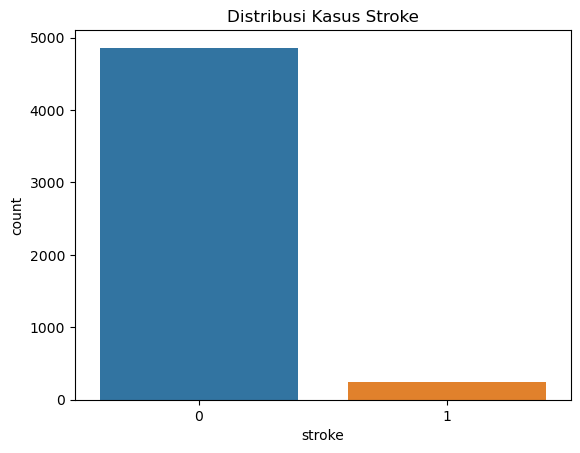

0    4861
1     249
Name: stroke, dtype: int64


In [10]:
sns.countplot(x='stroke', data=df)
plt.title('Distribusi Kasus Stroke')
plt.show()

print(df['stroke'].value_counts())

Temuan:
* Proporsi stroke sangat kecil (±5%)
* Dataset sangat tidak seimbang (class imbalance)

Insight:

Kasus stroke tergolong jarang dalam populasi, sehingga analisis dan model prediksi perlu lebih fokus pada kemampuan mendeteksi kasus positif (recall) daripada sekadar akurasi keseluruhan.

### Usia & Stroke 

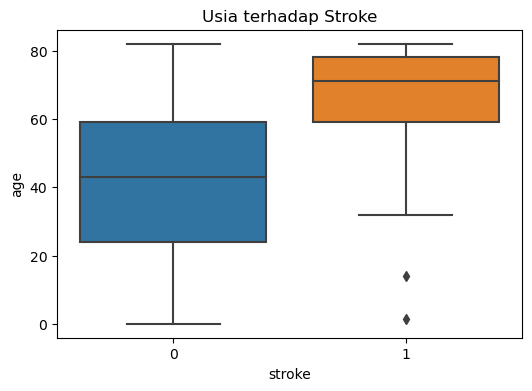

In [11]:
plt.figure(figsize=(6,4))
sns.boxplot(x='stroke', y='age', data=df)
plt.title("Usia terhadap Stroke")
plt.show()

Temuan:
* Median usia pasien stroke jauh lebih tinggi
* Hampir tidak ada kasus stroke pada usia muda
* Lonjakan kasus terlihat pada usia >55 tahun

Insight:

Usia merupakan faktor risiko paling dominan. Risiko stroke meningkat signifikan seiring pertambahan usia akibat penurunan fungsi pembuluh darah dan meningkatnya komorbiditas.

### Hipertensi & Stroke 

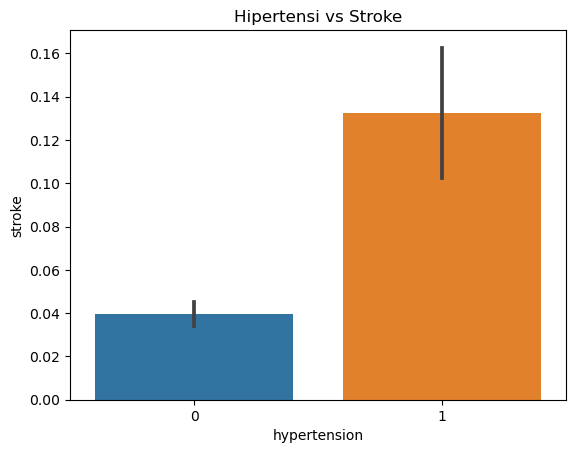

In [12]:
sns.barplot(x='hypertension', y='stroke', data=df)
plt.title("Hipertensi vs Stroke")
plt.show()

Temuan:
* Proporsi stroke pada pasien dengan hipertensi jauh lebih tinggi
* Selisih risiko terlihat jelas dibanding non-hipertensi

Insight:

Hipertensi merupakan faktor risiko utama stroke karena tekanan darah tinggi dapat merusak pembuluh darah otak dan memicu penyumbatan atau pecahnya pembuluh darah.

### Penyakit Jantung & Stroke 

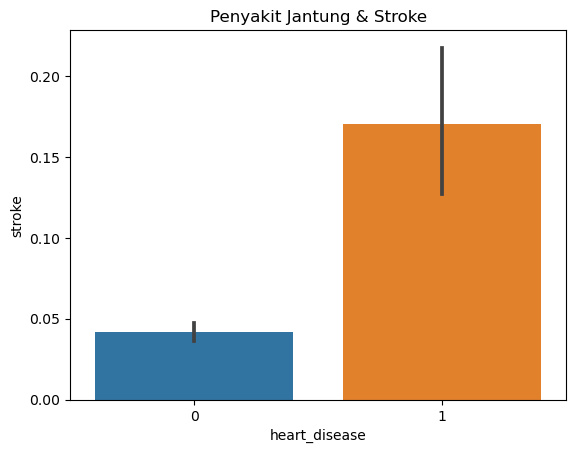

In [13]:
sns.barplot(x='heart_disease', y='stroke', data=df)
plt.title("Penyakit Jantung & Stroke")
plt.show()

Temuan:

Pasien dengan riwayat penyakit jantung memiliki tingkat stroke lebih tinggi

Insight:

Gangguan jantung meningkatkan kemungkinan terbentuknya bekuan darah yang dapat mengalir ke otak dan menyebabkan stroke.

### Kadar Glukosa

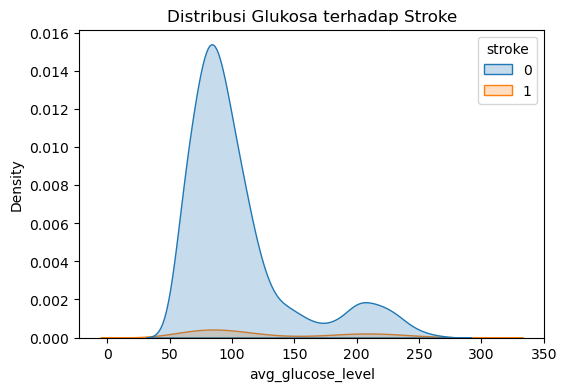

In [14]:
plt.figure(figsize=(6,4))
sns.kdeplot(data=df, x='avg_glucose_level', hue='stroke', fill=True)
plt.title("Distribusi Glukosa terhadap Stroke")
plt.show()

Temuan:
* Distribusi glukosa pasien stroke cenderung lebih tinggi
* Banyak kasus stroke berada pada rentang glukosa di atas normal

Insight:

Kadar glukosa tinggi (indikasi diabetes atau prediabetes) berkorelasi dengan peningkatan risiko stroke karena dapat merusak pembuluh darah dalam jangka panjang.

### BMI

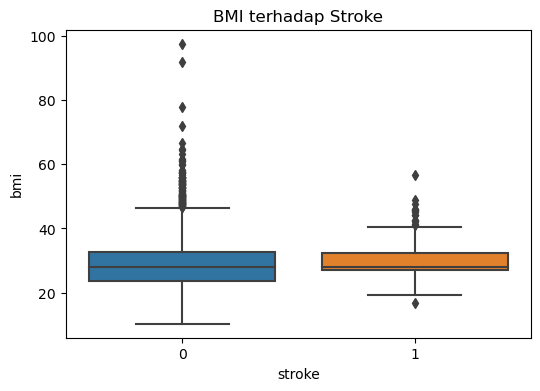

In [15]:
plt.figure(figsize=(6,4))
sns.boxplot(x='stroke', y='bmi', data=df)
plt.title("BMI terhadap Stroke")
plt.show()

Temuan:
* Rata-rata BMI pasien stroke sedikit lebih tinggi
* Namun terdapat overlap besar dengan non-stroke

Insight:

Obesitas berkontribusi terhadap risiko stroke, tetapi dampaknya tidak sekuat usia, hipertensi, atau kadar glukosa. BMI kemungkinan berperan secara tidak langsung melalui peningkatan risiko hipertensi dan diabetes.

### Status Merokok

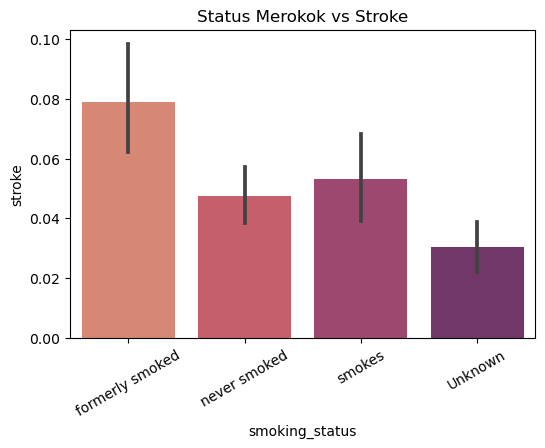

In [16]:
plt.figure(figsize=(6,4))
sns.barplot(x='smoking_status', y='stroke', data=df, palette='flare')
plt.title("Status Merokok vs Stroke")
plt.xticks(rotation=30)
plt.show()

Temuan:
* Kelompok formerly smoked sering menunjukkan proporsi stroke tertinggi
* Never smoked cenderung paling rendah

Insight:

Riwayat merokok meningkatkan risiko stroke akibat kerusakan pembuluh darah. Tingginya risiko pada mantan perokok juga dapat dipengaruhi faktor usia dan kondisi kesehatan sebelumnya.

### Gender & Stroke 

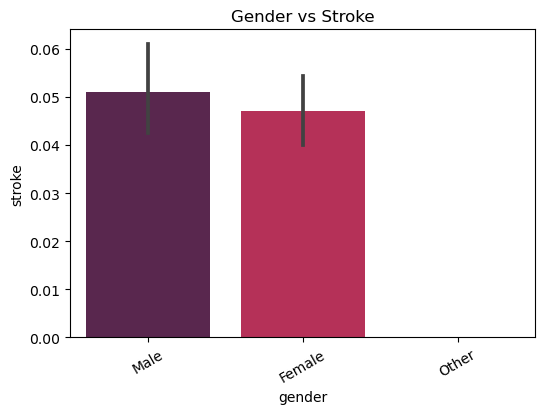

In [17]:
plt.figure(figsize=(6,4))
sns.barplot(x='gender', y='stroke', data=df, palette='rocket')
plt.title("Gender vs Stroke")
plt.xticks(rotation=30)
plt.show()

Temuan:

Perbedaan proporsi stroke antara laki-laki dan perempuan tidak terlalu besar

Insight:

Gender bukan faktor risiko dominan secara mandiri. Pengaruhnya lebih terlihat setelah dikombinasikan dengan faktor usia dan kondisi kesehatan lain.

## Data Preprocessing 

In [18]:
# Encoder data (mengubah tipe data)

le = LabelEncoder()

df['gender'] = le.fit_transform(df['gender'])
df['ever_married'] = le.fit_transform(df['ever_married'])
df['work_type'] = le.fit_transform(df['work_type'])
df['Residence_type'] = le.fit_transform(df['Residence_type'])
df['smoking_status'] = le.fit_transform(df['smoking_status'])
df['bmi'] = le.fit_transform(df['bmi'])

df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,1,2,1,228.69,239,1,1
1,0,61.0,0,0,1,3,0,202.21,154,2,1
2,1,80.0,0,1,1,2,0,105.92,198,2,1
3,0,49.0,0,0,1,2,1,171.23,217,3,1
4,0,79.0,1,0,1,3,0,174.12,113,2,1


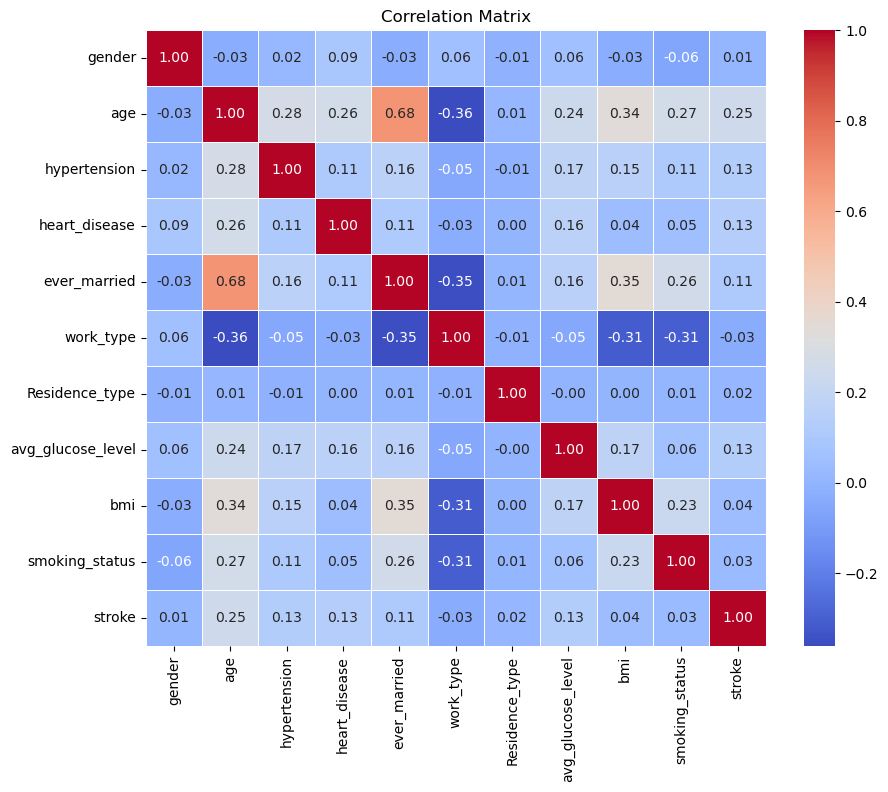

In [19]:
plt.figure(figsize=(10,8))
corr = df.corr()

sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

In [20]:
corr_target = corr['stroke'].sort_values(ascending=False)
print(corr_target)

stroke               1.000000
age                  0.245257
heart_disease        0.134914
avg_glucose_level    0.131945
hypertension         0.127904
ever_married         0.108340
bmi                  0.039473
smoking_status       0.028123
Residence_type       0.015458
gender               0.008929
work_type           -0.032316
Name: stroke, dtype: float64


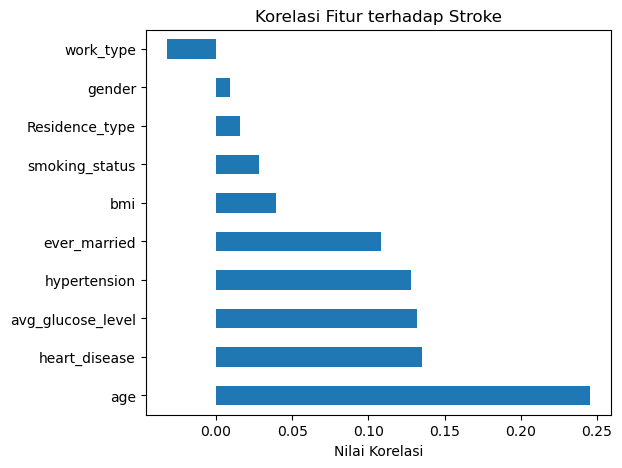

In [21]:
plt.figure(figsize=(6,5))
corr_target.drop('stroke').plot(kind='barh')
plt.title("Korelasi Fitur terhadap Stroke")
plt.xlabel("Nilai Korelasi")
plt.show()

Insight :

Analisis korelasi menunjukkan bahwa usia memiliki hubungan paling kuat dengan kejadian stroke dibanding variabel lain. Faktor medis seperti hipertensi, penyakit jantung, dan kadar glukosa juga menunjukkan korelasi positif, menandakan bahwa kondisi kardiovaskular dan metabolik berperan besar dalam risiko stroke. Variabel seperti jenis kelamin dan tipe tempat tinggal menunjukkan korelasi sangat lemah, sehingga bukan faktor utama dalam prediksi stroke pada dataset ini.

## Model Prediksi 

### Pemisahan Fitur dan Target 

Pada tahap ini, dataset dipisahkan menjadi variabel prediktor (fitur) dan variabel target yang akan diprediksi oleh model.

Variabel stroke dipilih sebagai target karena merepresentasikan kondisi yang ingin dianalisis, yaitu apakah seorang pasien mengalami stroke atau tidak. Seluruh kolom lainnya digunakan sebagai fitur karena berisi informasi demografis, kondisi kesehatan, dan gaya hidup yang berpotensi memengaruhi risiko stroke.

In [22]:
x = df.drop(columns='stroke',axis=1)
y = df['stroke']

Di mana:

X (features) berisi variabel seperti usia, hipertensi, penyakit jantung, kadar glukosa, BMI, status merokok, dan faktor lainnya

y (target) berisi label biner:
* 0 → Tidak mengalami stroke
* 1 → Mengalami stroke

### Feature Scaling (Standardization) 

Pada tahap ini dilakukan proses standarisasi fitur numerik menggunakan StandardScaler. Tujuannya adalah untuk menyamakan skala antar variabel agar model machine learning dapat belajar dengan lebih optimal.

Beberapa fitur pada dataset, seperti usia, kadar glukosa, dan BMI, memiliki rentang nilai yang sangat berbeda. Tanpa scaling, model dapat menjadi bias terhadap fitur dengan nilai yang lebih besar karena dianggap lebih “penting” secara numerik.

In [23]:
scaler = StandardScaler()
scaler.fit(x)
x = scaler.transform(x)

### Pembagian Data Latih dan Data Uji 

Setelah seluruh fitur dipersiapkan, dataset dibagi menjadi dua bagian: data latih (training set) dan data uji (testing set). Tujuan pembagian ini adalah untuk mengevaluasi performa model pada data yang belum pernah dilihat sebelumnya, sehingga hasil evaluasi lebih realistis.

In [24]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2 , random_state=42)

Penjelasan parameter:

* test_size=0.2 → 20% data digunakan untuk pengujian model, 80% untuk pelatihan
* random_state=42 → memastikan pembagian data konsisten setiap kali kode dijalankan (reproducible)

### Pembuatan Model Decision Tree 

Pada tahap ini digunakan algoritma Decision Tree Classifier untuk memprediksi kemungkinan seseorang mengalami stroke berdasarkan fitur kesehatan dan demografis.

Decision Tree bekerja dengan membagi data ke dalam cabang-cabang keputusan berdasarkan fitur yang paling informatif, hingga menghasilkan prediksi akhir dalam bentuk kelas (stroke atau tidak).

In [25]:
clf = DecisionTreeClassifier()
clf.fit(x_train, y_train)

pred = clf.predict(x_test)

dtc = accuracy_score(y_test, pred)
print (classification_report(y_test, pred))
print ('Akurasi Model Decision Tree : ', dtc)

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       960
           1       0.19      0.16      0.17        62

    accuracy                           0.91      1022
   macro avg       0.57      0.56      0.56      1022
weighted avg       0.90      0.91      0.90      1022

Akurasi Model Decision Tree :  0.9060665362035225


Insight:

* Accuracy : Akurasi terlihat tinggi (>90%), namun metrik ini menyesatkan karena data sangat tidak seimbang (kasus stroke sangat sedikit).
* Recall : Model hanya berhasil mendeteksi sekitar 16% pasien stroke, artinya sebagian besar pasien stroke terlewat (false negative). Dalam konteks kesehatan, ini berisiko tinggi karena pasien berbahaya dianggap sehat.
* Precision : Dari semua pasien yang diprediksi stroke, hanya sekitar 21% yang benar-benar stroke. Masih banyak false alarm, tapi ini lebih bisa ditoleransi dibanding gagal mendeteksi pasien stroke.
* Spesifitas : Model sangat baik dalam mengenali pasien tidak stroke, tapi itu terjadi karena mayoritas data memang bukan stroke.

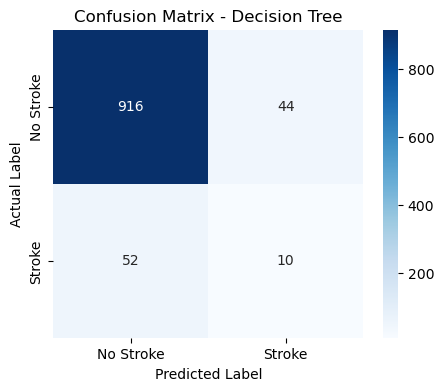

In [26]:
cm = confusion_matrix(y_test, pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Stroke', 'Stroke'],
            yticklabels=['No Stroke', 'Stroke'])

plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix - Decision Tree")
plt.show()

## Testing Model 

In [ ]:
import numpy as np

print("=== Input Data Pasien ===")

gender = int(input("Gender (0 = Female, 1 = Male): "))
age = float(input("Age: "))
hypertension = int(input("Hypertension (0 = No, 1 = Yes): "))
heart_disease = int(input("Heart Disease (0 = No, 1 = Yes): "))
ever_married = int(input("Ever Married (0 = No, 1 = Yes): "))
work_type = int(input("Work Type (0=Govt,1=Never worked,2=Private,3=Self-employed,4=Children): "))
residence_type = int(input("Residence Type (0 = Rural, 1 = Urban): "))
avg_glucose_level = float(input("Average Glucose Level: "))
bmi = float(input("BMI: "))
smoking_status = int(input("Smoking Status (0=Unknown,1=Formerly smoked,2=Never smoked,3=Smokes): "))

# Gabungkan ke array
input_data = np.array([[gender, age, hypertension, heart_disease, ever_married,
                        work_type, residence_type, avg_glucose_level, bmi, smoking_status]])
print("==========================")
data_tes = input_data.reshape(1,-1)
std_data = scaler.transform(data_tes)
print(std_data)

pred = clf.predict(std_data)
print (pred)

if (pred[0] == 0):
    print ('\nPasien Tidak Terkena Stroke')
else :
    print ('Pasien Terkena Stroke')